<a href="https://colab.research.google.com/github/rosiekwon/smart_healthcare/blob/main/Medical_image_preprocessing_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/FlashChoi5657/Deepnoid-Education.git

Cloning into 'Deepnoid-Education'...
remote: Enumerating objects: 556, done.
remote: Counting objects: 100% (223/223), done.
remote: Compressing objects: 100% (214/214), done.
remote: Total 556 (delta 42), reused 175 (delta 8), pack-reused 333
Receiving objects: 100% (556/556), 156.41 MiB | 16.26 MiB/s, done.
Resolving deltas: 100% (109/109), done.


In [2]:
!pip install simpleitk --quiet

     |████████████████████████████████| 52.8 MB 14.2 MB/s 


In [3]:
import numpy as np 
import os
import matplotlib.pyplot as plt
import SimpleITK as sitk
from sklearn import metrics as skmet
from skimage import morphology
from skimage import measure
from skimage import exposure
from skimage.transform import rotate
import cv2 as cv
from keras.preprocessing import image as kimg

# Header Information #
Image Size =  (512, 512, 1)
Pixel Spacing =  (0.646484375, 0.646484375, 1.0)
Image Dimension =  3
Number of Pixel Components =  1
Minimum & Maximum pixel value(Min/Max) = -1000/1844
Image mean & std = -555.9083557128906, 518.929847210932


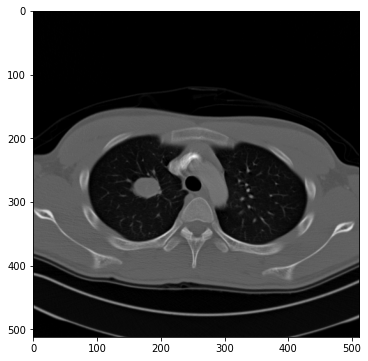

In [4]:
test_data = './Deepnoid-Education/dataset/test.dcm'
image = sitk.ReadImage(test_data) # simpleitk Object # 2d image load, nifti, NOT 3d image
img_arr = sitk.GetArrayFromImage(image)

print('# Header Information #')
print('Image Size = ', image.GetSize())
print('Pixel Spacing = ', image.GetSpacing())
print('Image Dimension = ', image.GetDimension())
print('Number of Pixel Components = ', image.GetNumberOfComponentsPerPixel())
print('Minimum & Maximum pixel value(Min/Max) = {}/{}'.format(np.min(img_arr), np.max(img_arr)))
print('Image mean & std = {}, {}'.format(np.mean(img_arr), np.std(img_arr)))

plt.figure(figsize=(6,6))
plt.imshow(img_arr[0], cmap='gray')

## Resize
- 이미지의 크기 변환

(1차원의 경우 linear interpolation, 2차원의 경우 bilinear interpolation 사용)

Original Image Size =  (512, 512, 1)
Processed Image Size =  (256, 256, 1)
Original Pixel Spacing =  (0.646484375, 0.646484375, 1.0)
Processed Pixel Spacing =  (1.29296875, 1.29296875, 1.0)


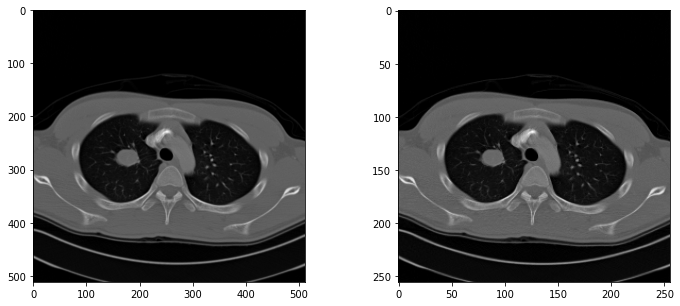

In [5]:
# Resize
def resize_array(sitk_image, size,interpolator=sitk.sitkLinear):
    original_spacing = sitk_image.GetSpacing()
    original_size = sitk_image.GetSize()
    new_size = list(original_size)
    new_size[0]=size[0]
    new_size[1]=size[1]
    new_spacing = [(ospc * osz / nsz) for osz, ospc, nsz in
                   zip(original_size, original_spacing, new_size)]
    sitk_image = sitk.Resample(sitk_image, new_size, sitk.Transform(), interpolator, 
                               sitk_image.GetOrigin(), new_spacing,
                         sitk_image.GetDirection(), 0, sitk_image.GetPixelID())
    return sitk_image

resize_img = resize_array(image, [256, 256])
print('Original Image Size = ', image.GetSize())
print('Processed Image Size = ', resize_img.GetSize())
print('Original Pixel Spacing = ', image.GetSpacing())
print('Processed Pixel Spacing = ', resize_img.GetSpacing())

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(img_arr[0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(sitk.GetArrayFromImage(resize_img)[0], cmap='gray') # (1,512,512) img_arr[0,...]

## Resample 
- 이미지의 픽셀간 물리적 거리 변화

픽셀 간 간격에 따라서 이미지가 확대 또는 축소 될 수 있다

변경될 이미지의 크기 = \(modified pixel spacing / original image size x original pixel spacing\)

Original Pixel Spacing =  (0.646484375, 0.646484375, 1.0)
Processed Pixel Spacing =  (1.0, 1.0, 1.0)
Original Image Size =  (512, 512, 1)
Processed Image Size =  (331, 331, 1)


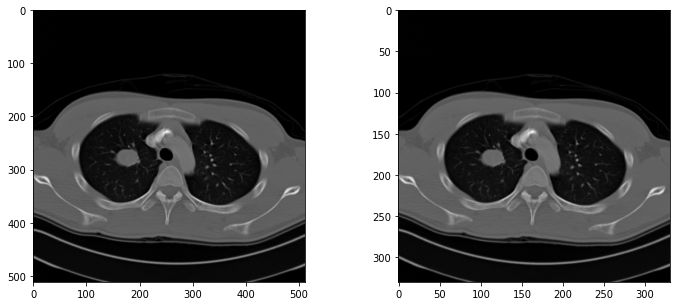

In [6]:
# Resample
def resample_array(sitk_image, spacing, interpolator=sitk.sitkLinear):
    original_spacing = sitk_image.GetSpacing()
    original_size = sitk_image.GetSize()
    new_spacing = [spacing, spacing, original_spacing[2]]
    new_size = [int(round(osz * ospc / nspc)) for osz, ospc, nspc in
                zip(original_size, original_spacing, new_spacing)]
    sitk_image = sitk.Resample(sitk_image, new_size, sitk.Transform(), interpolator, 
                               sitk_image.GetOrigin(), new_spacing,
                         sitk_image.GetDirection(), 0, sitk_image.GetPixelID())
    return sitk_image

resample_img = resample_array(image, 1)
print('Original Pixel Spacing = ', image.GetSpacing())
print('Processed Pixel Spacing = ', resample_img.GetSpacing())
print('Original Image Size = ', image.GetSize())
print('Processed Image Size = ', resample_img.GetSize())

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(img_arr[0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(sitk.GetArrayFromImage(resample_img)[0], cmap='gray')

## Normalization 
- 연산 효율 향상을 위해 이미지의 픽셀 값들을 0과 1 사이로 변경

𝜒_normalization = (𝜒−𝜒𝑚𝑖𝑛)/(𝜒𝑚𝑎𝑥 − 𝜒𝑚𝑖𝑛)

Oringinal Image min/max value = -1000/1844
Processed Image min/max value = 0.0/1.0

Sample Patch Comparison(Origin vs Processed)
[[144 141 114 109  94]
 [201 171 152 139 110]
 [396 309 242 179 153]
 [508 519 439 353 328]
 [375 430 452 463 476]]
[[0.40225035 0.4011955  0.39170183 0.38994374 0.38466948]
 [0.42229255 0.41174402 0.40506329 0.40049226 0.39029536]
 [0.49085795 0.46026723 0.43670886 0.41455696 0.40541491]
 [0.5302391  0.53410689 0.5059775  0.4757384  0.46694796]
 [0.48347398 0.50281294 0.51054852 0.51441632 0.51898734]]


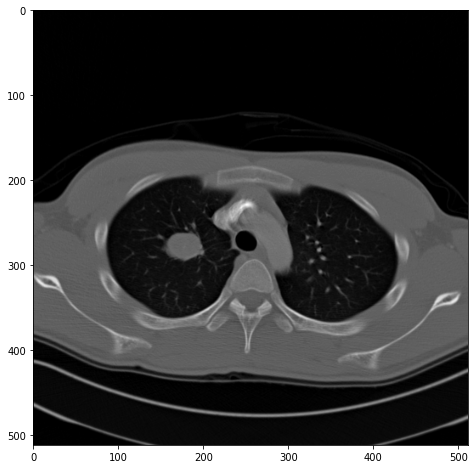

In [16]:
# MinMax Normalization
norm_img = (img_arr - np.min(img_arr)) / (np.max(img_arr) - np.min(img_arr))
print('Oringinal Image min/max value = {}/{}'.format(np.min(img_arr), np.max(img_arr)))
print('Processed Image min/max value = {}/{}'.format(np.min(norm_img), np.max(norm_img)))
print('\nSample Patch Comparison(Origin vs Processed)')
print(img_arr[0, 185:190, 275:280]) # z,y, x 
print(norm_img[0, 185:190, 275:280])

plt.figure(figsize=(8,8))
plt.imshow(norm_img[0], cmap='gray')

## Z-score normalization 
- 이상치에 영향을 덜 받도록 평균과 표준편차 이용

Z = (𝜒−𝜇)/𝜎

Oringinal Image min/max value = -1000/1844
Processed Image min/max value = -0.8557835836075877/4.62472599834364
Oringinal Image mean/std value = -555.9083557128906/518.929847210932
Processed Image mean/std value = -1.1102230246251565e-16/0.9999999999999999

Sample Patch Comparison(Origin vs Processed)
[[144 141 114 109  94]
 [201 171 152 139 110]
 [396 309 242 179 153]
 [508 519 439 353 328]
 [375 430 452 463 476]]
[[1.34875332 1.34297219 1.29094204 1.28130683 1.25240119]
 [1.45859476 1.40078348 1.36416966 1.33911811 1.28323387]
 [1.8343681  1.66671538 1.53760351 1.41619982 1.36609671]
 [2.05019688 2.07139435 1.91723093 1.75150526 1.70332919]
 [1.7939002  1.89988755 1.94228249 1.96347996 1.98853152]]


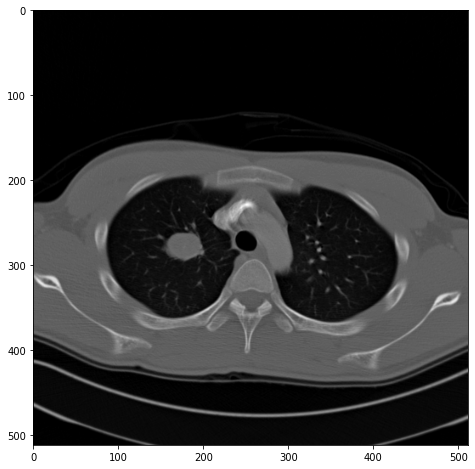

In [17]:
# Z-Score Normalization
zsc_img = (img_arr - np.mean(img_arr)) / np.std(img_arr)
print('Oringinal Image min/max value = {}/{}'.format(np.min(img_arr), np.max(img_arr)))
print('Processed Image min/max value = {}/{}'.format(np.min(zsc_img), np.max(zsc_img)))
print('Oringinal Image mean/std value = {}/{}'.format(np.mean(img_arr), np.std(img_arr)))
print('Processed Image mean/std value = {}/{}'.format(np.mean(zsc_img), np.std(zsc_img)))
print('\nSample Patch Comparison(Origin vs Processed)')
print(img_arr[0, 185:190, 275:280])
print(zsc_img[0, 185:190, 275:280])

plt.figure(figsize=(8,8))
plt.imshow(zsc_img[0], cmap='gray')

## Gamma correction
- 픽셀 값의 변화를 통해 이미지 밝기 보정

<img src='https://www.researchgate.net/profile/Varun-Gopi/publication/329571120/figure/fig2/AS:962661852385285@1606527879758/Gamma-correction-curve-for-different-values-of-gdocumentclass12ptminimal_Q640.jpg' height = 400 width = 400>

Oringinal Image mean/min/max value = 39.81834363333788/46.528520055832516
Processed Image mean/min/max value = 4.718105527925476/4.19020570625082


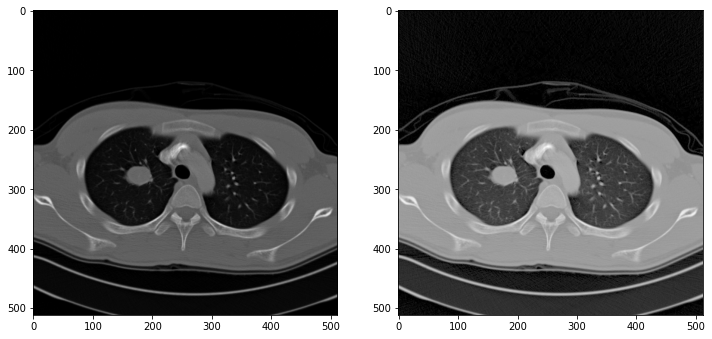

In [20]:
# Gamma Correction
gamma_cor = exposure.adjust_gamma(255*norm_img, 0.5)
print('Oringinal Image mean/min/max value = {}/{}'.format(np.mean(255*norm_img), np.std(255*norm_img)))
print('Processed Image mean/min/max value = {}/{}'.format(np.mean(gamma_cor), np.std(gamma_cor)))

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img_arr[0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(gamma_cor[0], cmap='gray')

## Adaptive Equalization
- 히스토그램 평활화를 수행하는 모듈

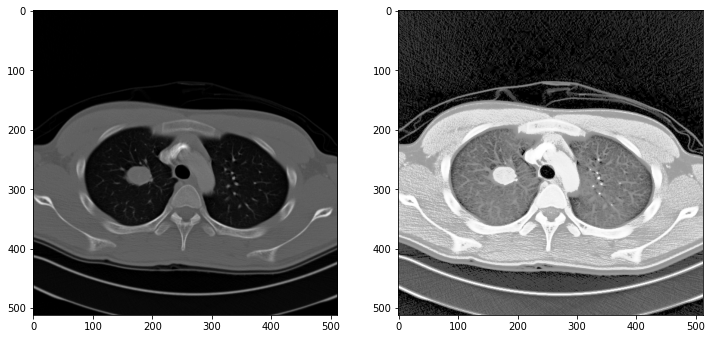

In [19]:
# Adaptive Equalization
img_eqh = exposure.equalize_hist(img_arr)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img_arr[0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img_eqh[0], cmap='gray')

# 데이터 증강기법

전체 Data의 N수가 부족할 때 주로 사용

-> 클래스 당 균형 잡힌 데이터를 학습시킬 수 있다

-> 데이터 수가 증가할 수록 핵심적인 특징이 부각된다

### rotation

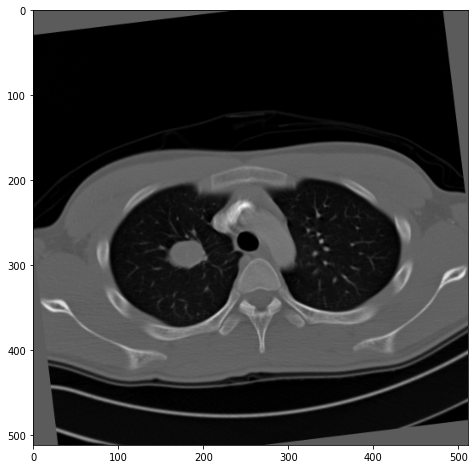

In [21]:
img_rot = rotate(img_arr[0], np.random.randint(0,30))
plt.figure(figsize=(8,8))
plt.imshow(img_rot, cmap='gray')
plt.show()

### shift

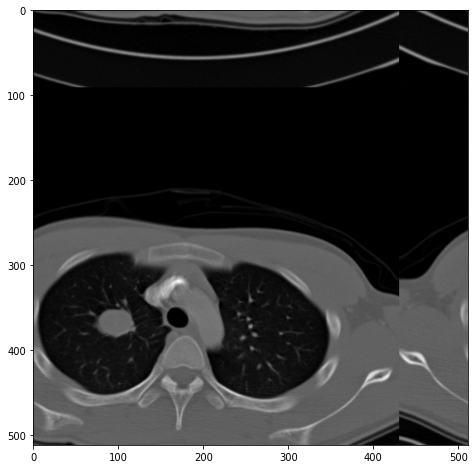

In [22]:
img_shift = kimg.random_shift(np.array(img_arr), 0.4, 0.4, fill_mode='wrap') # nearset, reflect, wrap
plt.figure(figsize=(8,8))
plt.imshow(img_shift[0], cmap='gray')
plt.show()

### horizontal_flip

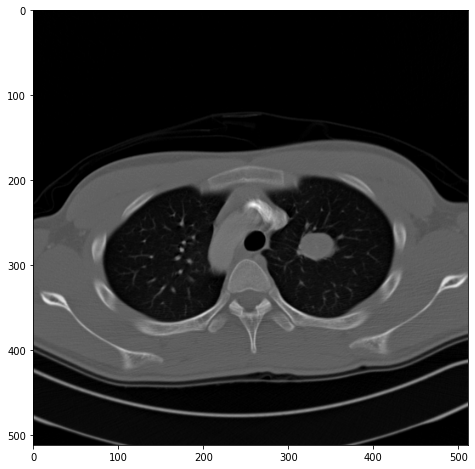

In [23]:
img_hflip = np.fliplr(img_arr[0])
plt.figure(figsize=(8,8))
plt.imshow(img_hflip, cmap='gray')
plt.show()

### vertical_flip

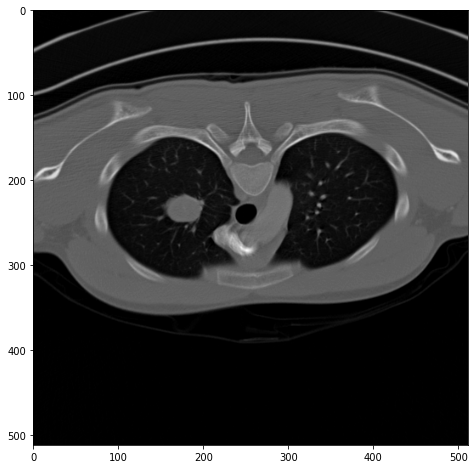

In [24]:
img_vflip = np.flipud(img_arr[0])
plt.figure(figsize=(8,8))
plt.imshow(img_vflip, cmap='gray')
plt.show()